In [9]:
import pandas as pd
import numpy as np # Pastikan semua import ada di cell awal

# GUNAKAN R'' UNTUK MENGHINDARI MASALAH BACKSLASH
# Ganti path di bawah dengan path ABSOLUTE (lengkap) di komputer Anda!
path_data = r'C:\Users\User\Documents\ai-course\df_arabica_clean.csv' 

try:
    df = pd.read_csv(path_data)
    print("Data berhasil dimuat. Head data:")
    print(df.head()) 
except Exception as e:
    print(f"Gagal memuat data. Error: {e}")

# Lanjutkan dengan import library lain setelah ini
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

Data berhasil dimuat. Head data:
   Aroma  Flavor  Total Cup Points
0   8.58    8.50             89.33
1   8.50    8.50             87.58
2   8.33    8.42             87.42
3   8.08    8.17             87.17
4   8.33    8.33             87.08


In [11]:
# Pastikan Anda menjalankan ini SETELAH df sudah dimuat.

# 1. Potong DataFrame menjadi 60 baris pertama
df_potong = df.iloc[0:60].copy()

# 2. Filter 3 Kolom yang Dibutuhkan (2 Input, 1 Output)
# KITA PAKAI KOLOM SESUAI NAMA DI OUTPUT ANDA: Aroma dan Flavor
df_fuzzy = df_potong[['Aroma', 'Flavor', 'Total Cup Points']].copy()

# 3. Tambahkan kolom Output sebagai referensi data asli
# Kita ganti nama kolom Total Cup Points data asli agar tidak bentrok dengan kolom Fuzzy
df_fuzzy['Total_Points_Data_Asli'] = df_fuzzy['Total Cup Points'] 

# Hapus kolom Total Cup Points asli (karena sudah disalin ke Total_Points_Data_Asli)
df_fuzzy = df_fuzzy.drop(columns=['Total Cup Points'])

print("Data berhasil dipotong menjadi 60 baris dan difilter:")
print(f"Jumlah baris: {len(df_fuzzy)}")
print(df_fuzzy.head())

Data berhasil dipotong menjadi 60 baris dan difilter:
Jumlah baris: 59
   Aroma  Flavor  Total_Points_Data_Asli
0   8.58    8.50                   89.33
1   8.50    8.50                   87.58
2   8.33    8.42                   87.42
3   8.08    8.17                   87.17
4   8.33    8.33                   87.08


In [1]:
import numpy as np
from skfuzzy import control as ctrl
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# --- 1. Tentukan Range Data dan Membership Function ---

# Range yang akurat dari data 60 baris Anda
RANGE_INPUT = np.arange(7.5, 9.1, 0.1)     # Range untuk Aroma dan Flavor
RANGE_OUTPUT = np.arange(84, 90.1, 0.1)    # Range untuk Total Cup Points (84-90)

# Definisikan Variabel Input
aroma = ctrl.Antecedent(RANGE_INPUT, 'aroma')
flavor = ctrl.Antecedent(RANGE_INPUT, 'flavor') 

# Definisikan Variabel Output
output_points = ctrl.Consequent(RANGE_OUTPUT, 'output_points')

# --- Fungsi Keanggotaan untuk AROMA dan FLAVOR (Input) ---
# Linguistik: Kurang (Poor), Biasa (Average), Prima (Excellent)
aroma['kurang'] = fuzz.trimf(aroma.universe, [7.5, 7.5, 8.0])
aroma['biasa'] = fuzz.trimf(aroma.universe, [7.8, 8.3, 8.8])
aroma['prima'] = fuzz.trimf(aroma.universe, [8.5, 9.0, 9.0])

# Flavor menggunakan batasan yang sama
flavor['kurang'] = fuzz.trimf(flavor.universe, [7.5, 7.5, 8.0])
flavor['biasa'] = fuzz.trimf(flavor.universe, [7.8, 8.3, 8.8])
flavor['prima'] = fuzz.trimf(flavor.universe, [8.5, 9.0, 9.0])


# --- Fungsi Keanggotaan untuk TOTAL CUP POINTS (Output) ---
# Linguistik: Standar, Premium, Eksotis
output_points['standar'] = fuzz.trimf(output_points.universe, [84, 85.5, 87])
output_points['premium'] = fuzz.trimf(output_points.universe, [86, 88, 89])
output_points['eksotis'] = fuzz.trimf(output_points.universe, [88.5, 90, 90])

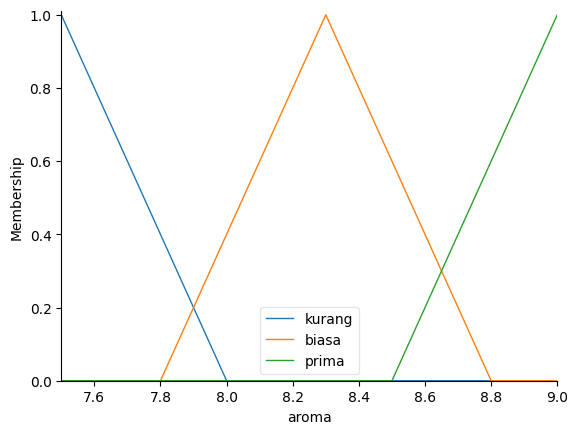

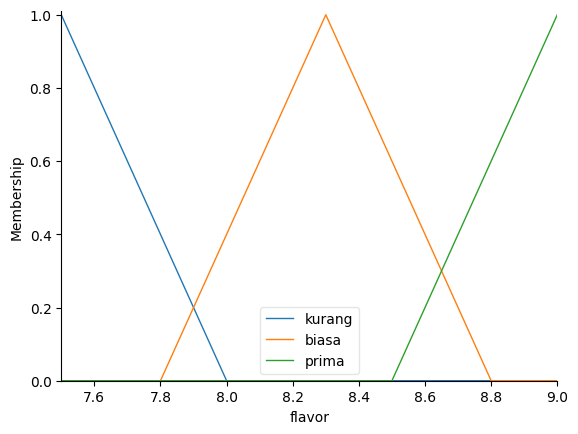

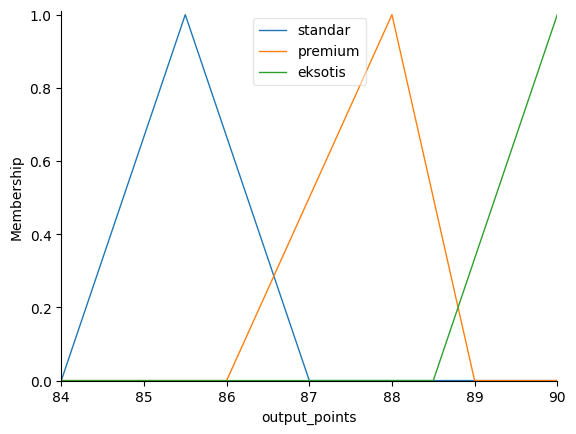

In [6]:
# Tampilkan visualisasi Membership Function untuk Aroma (Input)
aroma.view()
plt.show() 

# Tampilkan visualisasi Membership Function untuk Flavor (Input)
flavor.view()
plt.show() 

# Tampilkan visualisasi Membership Function untuk Total Cup Points (Output)
output_points.view()
plt.show()

In [7]:
# --- PASTIKAN KODE MEMBERSHIP FUNCTION SUDAH DIJALANKAN DI ATAS INI ---
# (Yang mendefinisikan: aroma, flavor, output_points, RANGE_INPUT, RANGE_OUTPUT)

# --- 1. Definisikan Rule Base (9 Aturan) ---
# Rule Standar
rule1 = ctrl.Rule(aroma['kurang'] & flavor['kurang'], output_points['standar'])
rule2 = ctrl.Rule(aroma['biasa'] & flavor['kurang'], output_points['standar'])
rule3 = ctrl.Rule(aroma['kurang'] & flavor['biasa'], output_points['standar'])

# Rule Premium
rule4 = ctrl.Rule(aroma['prima'] & flavor['kurang'], output_points['premium'])
rule5 = ctrl.Rule(aroma['biasa'] & flavor['biasa'], output_points['premium'])
rule6 = ctrl.Rule(aroma['kurang'] & flavor['prima'], output_points['premium'])
rule7 = ctrl.Rule(aroma['prima'] & flavor['biasa'], output_points['premium'])

# Rule Eksotis
rule8 = ctrl.Rule(aroma['biasa'] & flavor['prima'], output_points['eksotis'])
rule9 = ctrl.Rule(aroma['prima'] & flavor['prima'], output_points['eksotis'])

# --- 2. Buat Sistem Kontrol dan Simulasi ---
# Baris ini menyelesaikan error 'rule1 is not defined'
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
coffee_rating = ctrl.ControlSystemSimulation(tipping_ctrl)

# --- 3. Hasilkan Kolom Insight Baru ---
fuzzy_results = []
for index, row in df_fuzzy.iterrows():
    # Masukkan nilai input dari baris data
    coffee_rating.input['aroma'] = row['Aroma']
    coffee_rating.input['flavor'] = row['Flavor']
    
    try:
        coffee_rating.compute()
        fuzzy_results.append(coffee_rating.output['output_points'])
    except:
        fuzzy_results.append(np.nan) 
        
# BARIS KRUSIAL: Menciptakan kolom 'Total_Points_Fuzzy'
df_fuzzy['Total_Points_Fuzzy'] = fuzzy_results

print("Kolom Insight Baru Berhasil Dihasilkan.")


# --- 4. Plot Distribusi (Memecahkan KeyError) ---

# Plot Perbandingan Distribusi Data
plt.figure(figsize=(10, 6))
# Data Asli
plt.hist(df_fuzzy['Total_Points_Data_Asli'].dropna(), bins=8, alpha=0.6, label='Data Asli (60 Baris)')
# Hasil Fuzzy (Kolom yang baru dibuat)
plt.hist(df_fuzzy['Total_Points_Fuzzy'].dropna(), bins=8, alpha=0.6, label='Hasil Fuzzy')

plt.title('Perbandingan Distribusi Kualitas Kopi (Data Asli vs. Fuzzy)')
plt.xlabel('Total Cup Points Score')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

print("Tugas Implementasi Fuzzy Logic Selesai!")

NameError: name 'df_fuzzy' is not defined